# Method 8 - Best Ideas Medium Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['herf_pct'] > (1 / 3)) & (best_ideas['herf_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

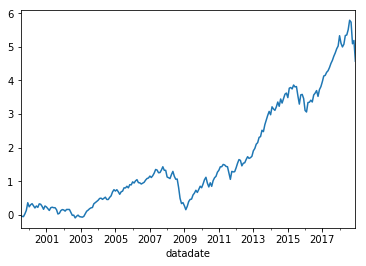

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.361533
2000-12-31   -0.071018
2001-12-31   -0.084802
2002-12-31   -0.180145
2003-12-31    0.474714
2004-12-31    0.250501
2005-12-31    0.081552
2006-12-31    0.108394
2007-12-31    0.108676
2008-12-31   -0.413182
2009-12-31    0.357297
2010-12-31    0.225768
2011-12-31    0.006313
2012-12-31    0.201003
2013-12-31    0.486343
2014-12-31    0.133952
2015-12-31   -0.035476
2016-12-31    0.079369
2017-12-31    0.251071
2018-12-31   -0.075103
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     507.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.53e-112
Time:                        06:23:00   Log-Likelihood:                 647.59
No. Observations:                 234   AIC:                            -1285.
Df Residuals:                     229   BIC:                            -1268.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.593      0.010       0.001       0.005
mktrf          1.0497      0.029     36.627      0.000       0.993       1.106
me             0.2373      0.033      7.119      0.000       0.172       0.303
ia            -0.0098      0.051     -0.193      0.847      -0.110       0.090
roe            0.1920      0.043      4.428      0.000       0.107       0.277
==============================================================================
Omnibus:                      131.499   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1974.786
Skew:                           1.826   Prob(JB):                         0.00
Kurtosis:                      16.755   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     786.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.79e-132
Time:                        06:23:00   Log-Likelihood:                 647.59
No. Observations:                 234   AIC:                            -1285.
Df Residuals:                     229   BIC:                            -1268.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.854      0.004       0.001       0.005
mktrf          1.0497      0.037     28.663      0.000       0.978       1.121
me             0.2373      0.041      5.821      0.000       0.157       0.317
ia            -0.0098      0.142     -0.069      0.945      -0.289       0.269
roe            0.1920      0.054      3.565      0.000       0.086       0.298
==============================================================================
Omnibus:                      131.499   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1974.786
Skew:                           1.826   Prob(JB):                         0.00
Kurtosis:                      16.755   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     1082.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.20e-147
Time:                        06:23:00   Log-Likelihood:                 647.59
No. Observations:                 234   AIC:                            -1285.
Df Residuals:                     229   BIC:                            -1268.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.982      0.003       0.001       0.004
mktrf          1.0497      0.039     26.962      0.000       0.973       1.126
me             0.2373      0.033      7.218      0.000       0.173       0.302
ia            -0.0098      0.130     -0.076      0.940      -0.264       0.244
roe            0.1920      0.056      3.444      0.001       0.083       0.301
==============================================================================
Omnibus:                      131.499   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1974.786
Skew:                           1.826   Prob(JB):                         0.00
Kurtosis:                      16.755   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     363.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.73e-106
Time:                        06:23:00   Log-Likelihood:                 636.52
No. Observations:                 234   AIC:                            -1261.
Df Residuals:                     228   BIC:                            -1240.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.584      0.010       0.001       0.005
mktrf          1.0273      0.030     34.050      0.000       0.968       1.087
smb            0.2533      0.040      6.363      0.000       0.175       0.332
hml           -0.0371      0.047     -0.791      0.430      -0.130       0.055
rmw            0.1408      0.053      2.652      0.009       0.036       0.245
cma            0.0201      0.067      0.297      0.766      -0.113       0.153
==============================================================================
Omnibus:                      115.936   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1648.018
Skew:                           1.544   Prob(JB):                         0.00
Kurtosis:                      15.629   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     509.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.63e-121
Time:                        06:23:00   Log-Likelihood:                 636.52
No. Observations:                 234   AIC:                            -1261.
Df Residuals:                     228   BIC:                            -1240.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.552      0.011       0.001       0.005
mktrf          1.0273      0.034     30.564      0.000       0.961       1.093
smb            0.2533      0.028      8.920      0.000       0.198       0.309
hml           -0.0371      0.060     -0.615      0.538      -0.155       0.081
rmw            0.1408      0.043      3.258      0.001       0.056       0.225
cma            0.0201      0.147      0.137      0.891      -0.267       0.307
==============================================================================
Omnibus:                      115.936   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1648.018
Skew:                           1.544   Prob(JB):                         0.00
Kurtosis:                      15.629   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     537.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.79e-124
Time:                        06:23:00   Log-Likelihood:                 636.52
No. Observations:                 234   AIC:                            -1261.
Df Residuals:                     228   BIC:                            -1240.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.534      0.011       0.001       0.005
mktrf          1.0273      0.034     30.428      0.000       0.961       1.094
smb            0.2533      0.027      9.339      0.000       0.200       0.306
hml           -0.0371      0.063     -0.589      0.556      -0.161       0.086
rmw            0.1408      0.041      3.447      0.001       0.061       0.221
cma            0.0201      0.139      0.144      0.886      -0.253       0.293
==============================================================================
Omnibus:                      115.936   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1648.018
Skew:                           1.544   Prob(JB):                         0.00
Kurtosis:                      15.629   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     572.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.10e-118
Time:                        06:23:00   Log-Likelihood:                 660.30
No. Observations:                 234   AIC:                            -1311.
Df Residuals:                     229   BIC:                            -1293.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.796      0.006       0.001       0.005
mktrf          1.0748      0.025     43.008      0.000       1.026       1.124
smb            0.1259      0.031      4.035      0.000       0.064       0.187
hml            0.0954      0.031      3.079      0.002       0.034       0.156
umd            0.1654      0.020      8.137      0.000       0.125       0.206
==============================================================================
Omnibus:                       88.460   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              682.325
Skew:                           1.255   Prob(JB):                    6.84e-149
Kurtosis:                      10.980   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     567.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.50e-117
Time:                        06:23:00   Log-Likelihood:                 660.30
No. Observations:                 234   AIC:                            -1311.
Df Residuals:                     229   BIC:                            -1293.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.860      0.004       0.001       0.005
mktrf          1.0748      0.040     26.998      0.000       0.997       1.153
smb            0.1259      0.051      2.482      0.013       0.026       0.225
hml            0.0954      0.075      1.274      0.202      -0.051       0.242
umd            0.1654      0.045      3.688      0.000       0.078       0.253
==============================================================================
Omnibus:                       88.460   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              682.325
Skew:                           1.255   Prob(JB):                    6.84e-149
Kurtosis:                      10.980   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     780.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.98e-132
Time:                        06:23:00   Log-Likelihood:                 660.30
No. Observations:                 234   AIC:                            -1311.
Df Residuals:                     229   BIC:                            -1293.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.769      0.006       0.001       0.005
mktrf          1.0748      0.037     28.951      0.000       1.002       1.148
smb            0.1259      0.053      2.369      0.018       0.022       0.230
hml            0.0954      0.072      1.319      0.187      -0.046       0.237
umd            0.1654      0.043      3.864      0.000       0.082       0.249
==============================================================================
Omnibus:                       88.460   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              682.325
Skew:                           1.255   Prob(JB):                    6.84e-149
Kurtosis:                      10.980   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     207.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.44e-51
Time:                        06:23:00   Log-Likelihood:                 307.41
No. Observations:                 120   AIC:                            -604.8
Df Residuals:                     115   BIC:                            -590.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.845      0.068      -0.000       0.007
mktrf          1.1261      0.049     22.905      0.000       1.029       1.223
me             0.2429      0.049      5.001      0.000       0.147       0.339
ia             0.0262      0.076      0.344      0.731      -0.124       0.177
roe            0.2980      0.067      4.427      0.000       0.165       0.431
==============================================================================
Omnibus:                       74.780   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.777
Skew:                           1.917   Prob(JB):                    4.79e-137
Kurtosis:                      13.529   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     273.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.06e-58
Time:                        06:23:00   Log-Likelihood:                 307.41
No. Observations:                 120   AIC:                            -604.8
Df Residuals:                     115   BIC:                            -590.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      2.025      0.043       0.000       0.007
mktrf          1.1261      0.053     21.312      0.000       1.022       1.230
me             0.2429      0.042      5.720      0.000       0.160       0.326
ia             0.0262      0.179      0.146      0.884      -0.324       0.376
roe            0.2980      0.056      5.276      0.000       0.187       0.409
==============================================================================
Omnibus:                       74.780   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.777
Skew:                           1.917   Prob(JB):                    4.79e-137
Kurtosis:                      13.529   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     342.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.41e-63
Time:                        06:23:00   Log-Likelihood:                 307.41
No. Observations:                 120   AIC:                            -604.8
Df Residuals:                     115   BIC:                            -590.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      2.186      0.029       0.000       0.006
mktrf          1.1261      0.050     22.581      0.000       1.028       1.224
me             0.2429      0.037      6.630      0.000       0.171       0.315
ia             0.0262      0.158      0.165      0.869      -0.284       0.336
roe            0.2980      0.045      6.579      0.000       0.209       0.387
==============================================================================
Omnibus:                       74.780   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.777
Skew:                           1.917   Prob(JB):                    4.79e-137
Kurtosis:                      13.529   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     137.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.32e-46
Time:                        06:23:00   Log-Likelihood:                 298.23
No. Observations:                 120   AIC:                            -584.5
Df Residuals:                     114   BIC:                            -567.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      1.991      0.049    2.02e-05       0.008
mktrf          1.1012      0.056     19.590      0.000       0.990       1.213
smb            0.2699      0.064      4.240      0.000       0.144       0.396
hml           -0.1103      0.078     -1.413      0.160      -0.265       0.044
rmw            0.2439      0.092      2.651      0.009       0.062       0.426
cma            0.1184      0.101      1.175      0.242      -0.081       0.318
==============================================================================
Omnibus:                       53.119   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              345.185
Skew:                           1.294   Prob(JB):                     1.11e-75
Kurtosis:                      10.895   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     210.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.45e-56
Time:                        06:23:00   Log-Likelihood:                 298.23
No. Observations:                 120   AIC:                            -584.5
Df Residuals:                     114   BIC:                            -567.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.151      0.031       0.000       0.008
mktrf          1.1012      0.065     16.834      0.000       0.973       1.229
smb            0.2699      0.046      5.857      0.000       0.180       0.360
hml           -0.1103      0.104     -1.065      0.287      -0.313       0.093
rmw            0.2439      0.092      2.657      0.008       0.064       0.424
cma            0.1184      0.175      0.676      0.499      -0.225       0.462
==============================================================================
Omnibus:                       53.119   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              345.185
Skew:                           1.294   Prob(JB):                     1.11e-75
Kurtosis:                      10.895   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     218.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.03e-56
Time:                        06:23:00   Log-Likelihood:                 298.23
No. Observations:                 120   AIC:                            -584.5
Df Residuals:                     114   BIC:                            -567.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.222      0.026       0.000       0.008
mktrf          1.1012      0.063     17.525      0.000       0.978       1.224
smb            0.2699      0.042      6.485      0.000       0.188       0.351
hml           -0.1103      0.106     -1.036      0.300      -0.319       0.098
rmw            0.2439      0.081      3.014      0.003       0.085       0.402
cma            0.1184      0.169      0.699      0.484      -0.213       0.450
==============================================================================
Omnibus:                       53.119   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              345.185
Skew:                           1.294   Prob(JB):                     1.11e-75
Kurtosis:                      10.895   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     241.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.88e-55
Time:                        06:23:00   Log-Likelihood:                 315.57
No. Observations:                 120   AIC:                            -621.1
Df Residuals:                     115   BIC:                            -607.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.002      3.111      0.002       0.002       0.009
mktrf          1.1406      0.040     28.189      0.000       1.060       1.221
smb            0.0722      0.046      1.567      0.120      -0.019       0.163
hml            0.1114      0.046      2.415      0.017       0.020       0.203
umd            0.2044      0.028      7.183      0.000       0.148       0.261
==============================================================================
Omnibus:                       37.712   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.589
Skew:                           1.082   Prob(JB):                     2.40e-27
Kurtosis:                       7.454   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     327.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.54e-62
Time:                        06:23:00   Log-Likelihood:                 315.57
No. Observations:                 120   AIC:                            -621.1
Df Residuals:                     115   BIC:                            -607.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.001      3.565      0.000       0.002       0.008
mktrf          1.1406      0.055     20.688      0.000       1.033       1.249
smb            0.0722      0.056      1.299      0.194      -0.037       0.181
hml            0.1114      0.088      1.266      0.205      -0.061       0.284
umd            0.2044      0.050      4.117      0.000       0.107       0.302
==============================================================================
Omnibus:                       37.712   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.589
Skew:                           1.082   Prob(JB):                     2.40e-27
Kurtosis:                       7.454   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     583.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.44e-75
Time:                        06:23:00   Log-Likelihood:                 315.57
No. Observations:                 120   AIC:                            -621.1
Df Residuals:                     115   BIC:                            -607.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.001      3.756      0.000       0.002       0.008
mktrf          1.1406      0.044     25.818      0.000       1.054       1.227
smb            0.0722      0.054      1.345      0.179      -0.033       0.177
hml            0.1114      0.083      1.351      0.177      -0.050       0.273
umd            0.2044      0.041      4.930      0.000       0.123       0.286
==============================================================================
Omnibus:                       37.712   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.589
Skew:                           1.082   Prob(JB):                     2.40e-27
Kurtosis:                       7.454   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     655.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.05e-75
Time:                        06:23:00   Log-Likelihood:                 387.50
No. Observations:                 114   AIC:                            -765.0
Df Residuals:                     109   BIC:                            -751.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.280      0.001       0.001       0.004
mktrf          0.9850      0.024     40.533      0.000       0.937       1.033
me             0.2355      0.038      6.276      0.000       0.161       0.310
ia            -0.1832      0.052     -3.520      0.001      -0.286      -0.080
roe           -0.0773      0.046     -1.691      0.094      -0.168       0.013
==============================================================================
Omnibus:                        1.412   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                1.459
Skew:                           0.255   Prob(JB):                        0.482
Kurtosis:                       2.785   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1271.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.90e-90
Time:                        06:23:00   Log-Likelihood:                 387.50
No. Observations:                 114   AIC:                            -765.0
Df Residuals:                     109   BIC:                            -751.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.412      0.016       0.001       0.005
mktrf          0.9850      0.016     61.645      0.000       0.954       1.016
me             0.2355      0.042      5.651      0.000       0.154       0.317
ia            -0.1832      0.050     -3.687      0.000      -0.281      -0.086
roe           -0.0773      0.048     -1.608      0.108      -0.172       0.017
==============================================================================
Omnibus:                        1.412   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                1.459
Skew:                           0.255   Prob(JB):                        0.482
Kurtosis:                       2.785   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1456.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.35e-93
Time:                        06:23:00   Log-Likelihood:                 387.50
No. Observations:                 114   AIC:                            -765.0
Df Residuals:                     109   BIC:                            -751.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.213      0.027       0.000       0.005
mktrf          0.9850      0.016     61.523      0.000       0.954       1.016
me             0.2355      0.042      5.582      0.000       0.153       0.318
ia            -0.1832      0.050     -3.635      0.000      -0.282      -0.084
roe           -0.0773      0.038     -2.012      0.044      -0.153      -0.002
==============================================================================
Omnibus:                        1.412   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                1.459
Skew:                           0.255   Prob(JB):                        0.482
Kurtosis:                       2.785   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     589.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.22e-76
Time:                        06:23:00   Log-Likelihood:                 394.40
No. Observations:                 114   AIC:                            -776.8
Df Residuals:                     108   BIC:                            -760.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.285      0.024       0.000       0.003
mktrf          0.9927      0.022     45.295      0.000       0.949       1.036
smb            0.2168      0.036      6.093      0.000       0.146       0.287
hml           -0.0219      0.045     -0.482      0.631      -0.112       0.068
rmw           -0.1216      0.056     -2.189      0.031      -0.232      -0.011
cma           -0.1721      0.071     -2.440      0.016      -0.312      -0.032
==============================================================================
Omnibus:                        2.718   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.257   Jarque-Bera (JB):                2.130
Skew:                           0.274   Prob(JB):                        0.345
Kurtosis:                       3.385   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1268.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.71e-94
Time:                        06:23:00   Log-Likelihood:                 394.40
No. Observations:                 114   AIC:                            -776.8
Df Residuals:                     108   BIC:                            -760.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.693      0.090      -0.000       0.004
mktrf          0.9927      0.013     74.216      0.000       0.966       1.019
smb            0.2168      0.039      5.625      0.000       0.141       0.292
hml           -0.0219      0.053     -0.412      0.681      -0.126       0.082
rmw           -0.1216      0.042     -2.874      0.004      -0.205      -0.039
cma           -0.1721      0.068     -2.545      0.011      -0.305      -0.040
==============================================================================
Omnibus:                        2.718   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.257   Jarque-Bera (JB):                2.130
Skew:                           0.274   Prob(JB):                        0.345
Kurtosis:                       3.385   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1977.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.03e-104
Time:                        06:23:00   Log-Likelihood:                 394.40
No. Observations:                 114   AIC:                            -776.8
Df Residuals:                     108   BIC:                            -760.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.480      0.139      -0.001       0.004
mktrf          0.9927      0.012     81.200      0.000       0.969       1.017
smb            0.2168      0.038      5.726      0.000       0.143       0.291
hml           -0.0219      0.062     -0.351      0.726      -0.144       0.100
rmw           -0.1216      0.047     -2.598      0.009      -0.213      -0.030
cma           -0.1721      0.064     -2.694      0.007      -0.297      -0.047
==============================================================================
Omnibus:                        2.718   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.257   Jarque-Bera (JB):                2.130
Skew:                           0.274   Prob(JB):                        0.345
Kurtosis:                       3.385   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     681.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.14e-76
Time:                        06:23:00   Log-Likelihood:                 389.59
No. Observations:                 114   AIC:                            -769.2
Df Residuals:                     109   BIC:                            -755.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.374      0.172      -0.000       0.003
mktrf          1.0134      0.023     44.820      0.000       0.969       1.058
smb            0.2415      0.035      6.851      0.000       0.172       0.311
hml           -0.0376      0.036     -1.036      0.302      -0.110       0.034
umd            0.0428      0.027      1.563      0.121      -0.011       0.097
==============================================================================
Omnibus:                        1.250   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.535   Jarque-Bera (JB):                0.809
Skew:                           0.171   Prob(JB):                        0.667
Kurtosis:                       3.231   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1039.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.91e-86
Time:                        06:23:00   Log-Likelihood:                 389.59
No. Observations:                 114   AIC:                            -769.2
Df Residuals:                     109   BIC:                            -755.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.055      0.291      -0.001       0.003
mktrf          1.0134      0.018     57.467      0.000       0.979       1.048
smb            0.2415      0.036      6.619      0.000       0.170       0.313
hml           -0.0376      0.046     -0.811      0.417      -0.129       0.053
umd            0.0428      0.021      1.996      0.046       0.001       0.085
==============================================================================
Omnibus:                        1.250   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.535   Jarque-Bera (JB):                0.809
Skew:                           0.171   Prob(JB):                        0.667
Kurtosis:                       3.231   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1505.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.31e-94
Time:                        06:23:01   Log-Likelihood:                 389.59
No. Observations:                 114   AIC:                            -769.2
Df Residuals:                     109   BIC:                            -755.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.974      0.330      -0.001       0.003
mktrf          1.0134      0.016     63.748      0.000       0.982       1.045
smb            0.2415      0.034      7.151      0.000       0.175       0.308
hml           -0.0376      0.052     -0.723      0.470      -0.140       0.064
umd            0.0428      0.019      2.246      0.025       0.005       0.080
==============================================================================
Omnibus:                        1.250   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.535   Jarque-Bera (JB):                0.809
Skew:                           0.171   Prob(JB):                        0.667
Kurtosis:                       3.231   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""